## Initialization

In [1]:
# Standard library imports
import random
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import copy
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor

import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree, structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_sparse import SparseTensor, matmul

from tqdm.notebook import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

In [2]:
torch_geometric.__version__

'2.2.0'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Loading Dataset and Preprocessing

In [4]:
# Downloading Dataset (MovieLens 100K)
# url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
# extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'
user_path = './ml-latest-small/users.csv'

In [5]:
rating_df = pd.read_csv(rating_path)
print(len(rating_df))
display(rating_df.head())

100836


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
num_items = len(rating_df['movieId'].unique())
num_users = len(rating_df['userId'].unique())

print("Number of Unique Users : ", num_users)
print("Number of unique Items : ", num_items)

Number of Unique Users :  610
Number of unique Items :  9724


In [7]:
print(rating_df.movieId.max())
print(rating_df.userId.max())

193609
610


In [8]:
# Encoding preprocessing to match no. of unique Ids
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)

In [9]:
print(rating_df.movieId.max())
print(rating_df.userId.max())

9723
609


In [10]:
# Check distribution of ratings
print('Rating Distribution')
rating_df.groupby(['rating'])['rating'].count()

Rating Distribution


rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: rating, dtype: int64

## Visualize User-Item Interactions in Bipartite Graph

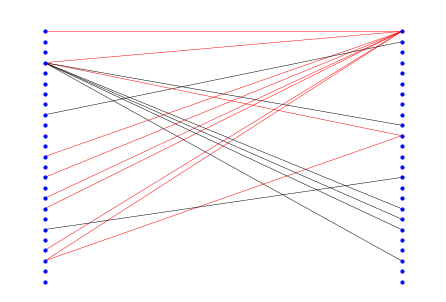

In [11]:
# Random subset of 50 users and 50 items
users = np.random.choice(rating_df['userId'].unique(), size=25, replace=False)
movies = np.random.choice(rating_df['movieId'].unique(), size=25, replace=False)

# Filter dataset and count no. of user-item interactions
ratings_subset = rating_df.loc[rating_df['userId'].isin(users) & rating_df['movieId'].isin(movies)]
item_counts = ratings_subset.groupby('movieId').size()

# Create bipartite graph
G = nx.Graph()
G.add_nodes_from(users, bipartite=0)
G.add_nodes_from(movies, bipartite=1)
for idx, row in ratings_subset.iterrows():
    color = 'r' if item_counts[row['movieId']] > 1 else 'k'
    G.add_edge(row['userId'], row['movieId'], color=color)

# Draw bipartite graph
pos = {node:[0, i] for i, node in enumerate(users)}
pos.update({node:[1, i] for i, node in enumerate(movies)})
edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
nx.draw(G, pos=pos, with_labels=False, node_size=10, width=0.5, node_color='b', edge_color=colors)

plt.show()

## Build Graph in Edge-Index Format

In [12]:
# Extract user-item interactions
rating_threshold = 3.5 # only using high-quality ratings for training
rating_mask = rating_df['rating'].values > rating_threshold
user_ids = rating_df.loc[rating_mask, 'userId'].values
item_ids = rating_df.loc[rating_mask, 'movieId'].values
interactions = np.ones_like(user_ids)

# Create sparse COO matrix representing user-item interactions
coo = sp.coo_matrix((interactions, (user_ids, item_ids)))
row, col, data = coo.row, coo.col, coo.data

# Edge Index (converted as LongTensor)
edge_index =  [row, col]
edge_index = torch.LongTensor(edge_index) 
print(edge_index)
print(edge_index.size())

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9443, 9444, 9445]])
torch.Size([2, 48580])


C:\Users\Sddddq\AppData\Local\Temp/ipykernel_13740/161207825.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  edge_index = torch.LongTensor(edge_index)


## Training and Validation Split

In [13]:
num_interactions = edge_index.shape[1]

# split the edges of the graph using a 80/10/10 train/validation/test split
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(all_indices, 
                                               test_size=0.2, 
                                               random_state=1)

val_indices, test_indices = train_test_split(test_indices, 
                                             test_size=0.5, 
                                             random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [14]:
print(f"num_users {num_users}, num_items {num_items}, num_interactions {num_interactions}")
print(f"train_edge_index {train_edge_index}")
print((num_users + num_items))
print(torch.unique(train_edge_index[0]).size())
print(torch.unique(train_edge_index[1]).size())

num_users 610, num_items 9724, num_interactions 48580
train_edge_index tensor([[ 605,  110,  442,  ...,   65,  161,  427],
        [1110, 9619, 1283,  ..., 4640,  443,  827]])
10334
torch.Size([609])
torch.Size([5676])


In [15]:
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index):
    R = torch.zeros((num_users, num_items))
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = 1

    R_transpose = R.T
    adj_mat = torch.zeros((num_users + num_items , num_users + num_items))
    adj_mat[: num_users, num_users :] = copy.deepcopy(R)
    adj_mat[num_users :, : num_users] = copy.deepcopy(R_transpose)
    adj_mat_coo = torch.nonzero(adj_mat).T
    return adj_mat_coo

In [16]:
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index):
    sparse_input_edge_index = SparseTensor(row=input_edge_index[0], 
                                           col=input_edge_index[1], 
                                           sparse_sizes=((num_users + num_items), num_users + num_items))
    adj_mat = sparse_input_edge_index.to_dense()
    interact_mat = adj_mat[: num_users, num_users :]
    interact_mat = sp.coo_matrix(interact_mat)
    r_mat_edge_index = torch.tensor(np.vstack((interact_mat.row, interact_mat.col)), dtype=torch.int64)
    return r_mat_edge_index

In [17]:
# convert from r_mat (interaction matrix) edge index to adjescency matrix's edge index 
# so we can feed it to model
train_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(train_edge_index)
val_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(val_edge_index)
test_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(test_edge_index)

In [18]:
print(train_edge_index)
print(train_edge_index.size())
print(val_edge_index)
print(val_edge_index.size())
print(test_edge_index)
print(test_edge_index.size())

tensor([[    0,     0,     0,  ..., 10326, 10327, 10333],
        [  610,   612,   653,  ...,   183,   183,   330]])
torch.Size([2, 77728])
tensor([[    0,     0,     0,  ..., 10226, 10236, 10240],
        [  615,   794,  2010,  ...,   317,   204,   413]])
torch.Size([2, 9716])
tensor([[    0,     0,     0,  ..., 10301, 10302, 10329],
        [  811,  1086,  1095,  ...,   585,   585,   183]])
torch.Size([2, 9716])


## LightGCN Model Implementation

#### LightGCN Propagation Rule:

\begin{equation}
e_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}} e_i^{(k)} \quad e_i^{(k+1)} = \sum_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}} e_u^{(k)}
\end{equation}

$N_u$: the set of all neighbors of user $u$ (items liked by $u$)

$N_i$: the set of all neighbors of item $i$ (users who liked $i$)

$e_u^{(k)}$ : k-th layer user embedding

$e_i^{(k)}$ : k-th layer item embedding


#### Layer Combination and Model Prediction
The only trainable parameters of LightGCN are the 0-th layer embeddings $e_u^{(0)}$ and $e_i^{(0)}$ for each user and item. We combine the embeddings obtained at each layer of propagation to form the final embeddings for all user and item, $e_u$ and $e_i$ via the follwing equation.


\begin{equation}
e_u = \sum_{k = 0}^K \alpha_k e_u^{(k)} \quad e_i = \sum_{k = 0}^K \alpha_k e_i^{(k)}
\end{equation}

$\alpha_k$ : hyperparameter which weights the contribution of the k-th layer embedding to the final embedding

#### Prediction: Taking inner product of final embeddings

\begin{equation}
\hat{y}_{ui} = e_u^Te_i
\end{equation}

#### Propagation Rule in Matrix Form:

\begin{equation}
E^{(K)} = \alpha_0 E^{(0)} + \alpha_1 \tilde{A}^1 E^{(0)} + \alpha_2 \tilde{A}^2 E^{(0)} + \cdot \cdot \cdot + \alpha_K \tilde{A}^K \tilde{A} E^{(0)}
\end{equation}

$E^{(0)} \in \mathcal{R}^{(M + N)} \times T$ : stacked initial item and user embeddings where $M$, $N$, and $T$ denote the number of users, number of items, and the embedding dimension respectively.

$\tilde{A} = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$ : symmetrically normalized adjacency matrix


In [19]:
# defines LightGCN model 
class LightGCN(MessagePassing):

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops

        # Define user and item embeddings
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0        
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        # Initialize user and item embeddings with normal distribution
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)
        
    # ---------------------------------------------------#
        
    def forward(self, edge_index: Tensor):
        """Forward propagation of LightGCN Model.
        
            Args: edge_index (SparseTensor): adjacency matrix
            Returns: tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        # where \tilde_A = D^(-1/2) * A * D^(-1/2)
        
        edge_index_norm = gcn_norm(edge_index=edge_index, 
                                   add_self_loops=self.add_self_loops)

        # Concatenate user-item embeddings (obtain initial embedding matrix E^0)
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight])
        embs = [emb_0] # init list of embeddings (capture group for all embedding outputs)
        emb_k = emb_0

        # Performing Message Propagation over K-Layers
        for i in range(self.K): # self.propagate inherited from PyG `MessagePassing` module
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)
        
        # Compute final embeddings by taking the average of all the intermediate embeddings.
        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1) # E^K
        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items]) # split into e_u^K and e_i^K

        # Return Output: e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight
    
    # ---------------------------------------------------#
    
    def message(self, x_j, norm): # Normalize neighboring node features 
        return norm.view(-1, 1) * x_j    

In [21]:
# INITIALIZE MODEL
layers = 3
model = LightGCN(num_users=num_users, num_items=num_items, K=layers)

## Minibatch Sampling

In [20]:
# Performs minibatch sampling on a set of edge indices for a graph dataset.
def sample_mini_batch(batch_size, edge_index):
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

## BPR Loss Function

We employ the Bayesian Personalized Ranking (BPR) loss, a pairwise objective which encourages the predictions of positive samples to be higher than negative samples for each user.

\begin{equation}
L_{BPR} = -\sum_{u = 1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln{\sigma(\hat{y}_{ui} - \hat{y}_{uj})} + \lambda ||E^{(0)}||^2 
\end{equation}

$\hat{y}_{u}$: predicted score of a positive sample

$\hat{y}_{uj}$: predicted score of a negative sample

$\lambda$: hyperparameter which controls the L2 regularization strength

In [58]:
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, 
             pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val, if_bpr_user=True):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): Embeddings of users after K message-passing layers (e_u_k)
        users_emb_0 (torch.Tensor): Initial embeddings of users (e_u_0)
        pos_items_emb_final (torch.Tensor): Embeddings of positive items after K message-passing layers (e_i_k)
        pos_items_emb_0 (torch.Tensor): Initial embeddings of positive items (e_i_0)
        neg_items_emb_final (torch.Tensor): Embeddings of negative items after K message-passing layers (e_i_k)
        neg_items_emb_0 (torch.Tensor): Initial embeddings of negative items (e_i_0)
        lambda_val (float): Regularization parameter for L2 loss.

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    if if_bpr_user:
        reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                                 pos_items_emb_0.norm(2).pow(2) +
                                 neg_items_emb_0.norm(2).pow(2)) # L2 loss
    else:
        reg_loss = lambda_val * (pos_items_emb_0.norm(2).pow(2) +
                                 neg_items_emb_0.norm(2).pow(2))

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples


    bpr_loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores))
    loss = bpr_loss + reg_loss
    
    return loss

## Evaluation Metrics

In [23]:
def get_user_positive_items(edge_index):
    """
    Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges 

    Returns:
        dict: user -> list of positive items for each 
    """
    
    # key: user_id, val: item_id list
    user_pos_items = {}
    
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        
        if user not in user_pos_items:
            user_pos_items[user] = []
        
        user_pos_items[user].append(item)
        
    return user_pos_items

In [24]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list[list[long]]): list of lists of item_ids. Cntaining highly rated items of each user. 
                            In other words, this is the list of true_relevant_items for each user
                            
        r (list[list[boolean]]): list of lists indicating whether each top k item recommended to each user
                            is a top k ground truth (true relevant) item or not
                            
        k (int): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    
    # number of correctly predicted items per user
    # -1 here means I want to sum at the inner most dimension
    num_correct_pred = torch.sum(r, dim=-1)  
    
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))])
    
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [25]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [26]:
def get_metrics(model, 
                input_edge_index, # adj_mat based edge index
                input_exclude_edge_indices, # adj_mat based exclude edge index
                k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    # get the embedding tensor at layer 0 after training
    try:
        user_embedding = model.users_emb.weight
    except:
        user_embedding = model.users_emb
    item_embedding = model.items_emb.weight
    

    # convert adj_mat based edge index to r_mat based edge index so we have have 
    # the first list being user_ids and second list being item_ids for the edge index 
    edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index)

    # This is to exclude the edges we have seen before in our predicted interaction matrix (r_mat_rating)
    # E.g: for validation set, we want want to exclude all the edges in training set
    exclude_edge_indices = [convert_adj_mat_edge_index_to_r_mat_edge_index(exclude_edge_index) \
                                      for exclude_edge_index in input_exclude_edge_indices]

     

    # Generate predicted interaction matrix (r_mat_rating)    
    # (num_users x 64) dot_product (num_item x 64).T 
    r_mat_rating = torch.matmul(user_embedding, item_embedding.T)
    
    # shape: num_users x num_item
    rating = r_mat_rating
   
    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        # it's a dict: user -> positive item list
        user_pos_items = get_user_positive_items(exclude_edge_index)
        
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            # [user] * len(item) can give us [user1, user1, user1...] with len of len(item)
            # this makes easier to do the masking below
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
   
        # set the excluded entry in the rat_mat_rating matrix to a very small number
        rating[exclude_users, exclude_items] = -(1 << 10) 

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    # dict of user -> pos_item list
    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list of lists
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]


    # r here is "pred_relevant_items ∩ actually_relevant_items" list for each user
    r = []
    for user in users:
        user_true_relevant_item = test_user_pos_items[user.item()]
        # list of Booleans to store whether or not a given item in the top_K_items for a given user 
        # is also present in user_true_relevant_item.
        # this is later on used to compute n_rel_and_rec_k
        label = list(map(lambda x: x in user_true_relevant_item, top_K_items[user]))
        r.append(label)
        
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [27]:
# wrapper function to evaluate model
def evaluation(model, 
               edge_index, # adj_mat based edge index
               exclude_edge_indices,  # adj_mat based exclude edge index
               k, 
               lambda_val
              ):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(edge_index)
    
    r_mat_edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index)
    
    edges = structured_negative_sampling(r_mat_edge_index, contains_neg_self_loops=False)
    
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, 
                    users_emb_0, 
                    pos_items_emb_final, 
                    pos_items_emb_0,
                    neg_items_emb_final, 
                    neg_items_emb_0, 
                    lambda_val).item()


    recall, precision, ndcg = get_metrics(model, 
                                          edge_index, 
                                          exclude_edge_indices, 
                                          k)

    return loss, recall, precision, ndcg

## Setting up for Model Training

In [28]:
ITERATIONS = 1000
EPOCHS = 10
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 20
ITERS_PER_LR_DECAY = 20
K = 20
LAMBDA = 1e-6

In [29]:
model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

In [30]:
def get_embs_for_bpr(model, input_edge_index):
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(input_edge_index)
    

    edge_index_to_use = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index)
    
    # mini batching for eval and calculate loss 
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, edge_index_to_use)
    
    # This is to push tensor to device so if we are using GPU
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)
    
 
    # we need layer0 embeddings and the final embeddings (computed from 0...K layer) for BPR loss computing
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]
   
    return users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0

## Model Training

In [31]:
# training loop
train_losses = []
val_losses = []
val_recall_at_ks = []

for iter in tqdm(range(ITERATIONS)):
    # forward propagation  
    users_emb_final, users_emb_0,  pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0 \
                = get_embs_for_bpr(model, train_edge_index)
    
    # loss computation
    train_loss = bpr_loss(users_emb_final, 
                          users_emb_0, 
                          pos_items_emb_final,
                          pos_items_emb_0, 
                          neg_items_emb_final, 
                          neg_items_emb_0, 
                          LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # validation set
    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        
        with torch.no_grad():
            val_loss, recall, precision, ndcg = evaluation(model, 
                                                           val_edge_index, 
                                                           [train_edge_index], 
                                                           K, 
                                                           LAMBDA
                                                          )

            print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")

            train_losses.append(train_loss.item())
            val_losses.append(val_loss)
            val_recall_at_ks.append(round(recall, 5))
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

[Iteration 0/1000] train_loss: -0.69285, val_loss: -0.6993, val_recall@20: 0.00172, val_precision@20: 0.00118, val_ndcg@20: 0.00197
[Iteration 20/1000] train_loss: -0.69759, val_loss: -0.70281, val_recall@20: 0.0016, val_precision@20: 0.00108, val_ndcg@20: 0.0019
[Iteration 40/1000] train_loss: -0.71858, val_loss: -0.72014, val_recall@20: 0.00338, val_precision@20: 0.00199, val_ndcg@20: 0.00369
[Iteration 60/1000] train_loss: -0.78382, val_loss: -0.7703, val_recall@20: 0.00764, val_precision@20: 0.0047, val_ndcg@20: 0.00729
[Iteration 80/1000] train_loss: -0.94107, val_loss: -0.87272, val_recall@20: 0.01562, val_precision@20: 0.0075, val_ndcg@20: 0.0118
[Iteration 100/1000] train_loss: -1.20602, val_loss: -1.05185, val_recall@20: 0.02814, val_precision@20: 0.01067, val_ndcg@20: 0.01778
[Iteration 120/1000] train_loss: -1.61024, val_loss: -1.32104, val_recall@20: 0.03506, val_precision@20: 0.0123, val_ndcg@20: 0.02276
[Iteration 140/1000] train_loss: -2.06375, val_loss: -1.6793, val_rec

## Evaluation of Results

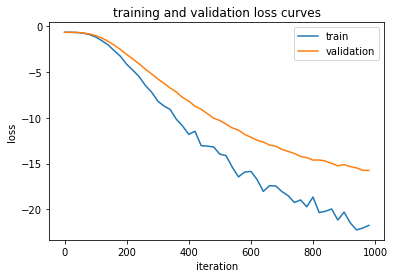

In [32]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

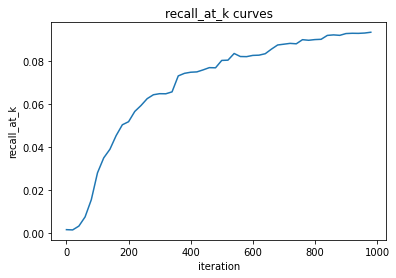

In [33]:
f2 = plt.figure()
plt.plot(iters, val_recall_at_ks, label='recall_at_k')
plt.xlabel('iteration')
plt.ylabel('recall_at_k')
plt.title('recall_at_k curves')
plt.show()

In [34]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(model, 
                                                               test_edge_index, 
                                                               [train_edge_index, val_edge_index], 
                                                               K, 
                                                               LAMBDA
                                                              )

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: -16.03881, test_recall@20: 0.08941, test_precision@20: 0.02826, test_ndcg@20: 0.05398


## Simple LightGCN

In [59]:
# defines LightGCN model 
class Simple_LightGCN(MessagePassing):

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops

        # Define user and item embeddings      
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0
        self.users_emb = torch.zeros((self.num_users, self.embedding_dim))

        # Initialize user and item embeddings with normal distribution
        nn.init.normal_(self.items_emb.weight, std=0.1)
        
    # ---------------------------------------------------#
        
    def forward(self, edge_index: Tensor):
        """Forward propagation of LightGCN Model.
        
            Args: edge_index (SparseTensor): adjacency matrix
            Returns: tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        # where \tilde_A = D^(-1/2) * A * D^(-1/2)
        
        edge_index_norm = gcn_norm(edge_index=edge_index, 
                                   add_self_loops=self.add_self_loops)
        r_edge_index_norm = gcn_norm(edge_index=convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index), 
                                   add_self_loops=self.add_self_loops)
        self.R = torch.zeros((self.num_users, self.num_items))
        for i in range(len(r_edge_index_norm[1])):
            row_idx = r_edge_index_norm[0][0][i]
            col_idx = r_edge_index_norm[0][1][i]
            self.R[row_idx][col_idx] = r_edge_index_norm[1][i]

        self.users_emb = self.R @ self.items_emb.weight.detach()

        # Concatenate user-item embeddings (obtain initial embedding matrix E^0)
        emb_0 = torch.cat([self.users_emb, self.items_emb.weight])
        embs = [emb_0] # init list of embeddings (capture group for all embedding outputs)
        emb_k = emb_0

        # Performing Message Propagation over K-Layers
        for i in range(self.K): # self.propagate inherited from PyG `MessagePassing` module
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)
        
        # Compute final embeddings by taking the average of all the intermediate embeddings.
        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1) # E^K
        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items]) # split into e_u^K and e_i^K

        # Return Output: e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb, items_emb_final, self.items_emb.weight
    
    # ---------------------------------------------------#
    
    def message(self, x_j, norm): # Normalize neighboring node features 
        return norm.view(-1, 1) * x_j    

In [100]:
# Same paramters as LightGCN
ITERATIONS = 1000
EPOCHS = 10
BATCH_SIZE = 1024
LR = 1e-4
ITERS_PER_EVAL = 20
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

In [101]:
# INITIALIZE MODEL
layers = 2
simple_model = Simple_LightGCN(num_users=num_users, num_items=num_items, K=layers)

In [102]:
simple_model = simple_model.to(device)
simple_model.train()

simple_optimizer = optim.Adam(simple_model.parameters(), lr=LR)
simple_scheduler = optim.lr_scheduler.ExponentialLR(simple_optimizer, gamma=0.95)

# edge_index = edge_index.to(device)
# train_edge_index = train_edge_index.to(device)
# val_edge_index = val_edge_index.to(device)

In [103]:
# training loop
simple_train_losses = []
simple_val_losses = []
simple_val_recall_at_ks = []
best_simple_val_recall = 0.0
print("Start Training Simple LightGCN ------------------------------------")
for iter in tqdm(range(ITERATIONS)):
    # forward propagation  
    s_users_emb_final, s_users_emb_0,  s_pos_items_emb_final, s_pos_items_emb_0, s_neg_items_emb_final, s_neg_items_emb_0 \
                = get_embs_for_bpr(simple_model, train_edge_index)
    
    # loss computation
    simple_train_loss = bpr_loss(s_users_emb_final, 
                          s_users_emb_0, 
                          s_pos_items_emb_final,
                          s_pos_items_emb_0, 
                          s_neg_items_emb_final, 
                          s_neg_items_emb_0, 
                          LAMBDA, if_bpr_user=False)

    simple_optimizer.zero_grad()
    simple_train_loss.backward()
    simple_optimizer.step()

    # validation set
    if iter % ITERS_PER_EVAL == 0:
        simple_model.eval()
        
        with torch.no_grad():
            simple_val_loss, simple_recall, simple_precision, simple_ndcg = evaluation(simple_model, 
                                                                                        val_edge_index, 
                                                                                        [train_edge_index], 
                                                                                        K, 
                                                                                        LAMBDA)

            print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(simple_train_loss.item(), 5)}, val_loss: {round(simple_val_loss, 5)}, val_recall@{K}: {round(simple_recall, 5)}, val_precision@{K}: {round(simple_precision, 5)}, val_ndcg@{K}: {round(simple_ndcg, 5)}")

            simple_train_losses.append(simple_train_loss.item())
            simple_val_losses.append(simple_val_loss)
            simple_val_recall_at_ks.append(round(simple_recall, 5))
            
            if simple_recall > best_simple_val_recall:
                best_simple_model = copy.deepcopy(simple_model)

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        simple_scheduler.step()

Start Training Simple LightGCN ------------------------------------


  0%|          | 0/1000 [00:00<?, ?it/s]

[Iteration 0/1000] train_loss: -0.71311, val_loss: -0.7365, val_recall@20: 0.24964, val_precision@20: 0.0557, val_ndcg@20: 0.26758
[Iteration 20/1000] train_loss: -0.71312, val_loss: -0.73722, val_recall@20: 0.24989, val_precision@20: 0.05588, val_ndcg@20: 0.26745
[Iteration 40/1000] train_loss: -0.72164, val_loss: -0.73694, val_recall@20: 0.25059, val_precision@20: 0.05642, val_ndcg@20: 0.2679
[Iteration 60/1000] train_loss: -0.73257, val_loss: -0.73844, val_recall@20: 0.2505, val_precision@20: 0.05651, val_ndcg@20: 0.26809
[Iteration 80/1000] train_loss: -0.7363, val_loss: -0.73933, val_recall@20: 0.25124, val_precision@20: 0.05696, val_ndcg@20: 0.26854
[Iteration 100/1000] train_loss: -0.75057, val_loss: -0.74133, val_recall@20: 0.2508, val_precision@20: 0.05678, val_ndcg@20: 0.26847
[Iteration 120/1000] train_loss: -0.76312, val_loss: -0.7423, val_recall@20: 0.25291, val_precision@20: 0.05769, val_ndcg@20: 0.26945
[Iteration 140/1000] train_loss: -0.79512, val_loss: -0.74413, val_r

In [106]:
# evaluate on test set
best_simple_model.eval()
test_edge_index = test_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(best_simple_model, 
                                                               test_edge_index, 
                                                               [train_edge_index, val_edge_index], 
                                                               K, 
                                                               LAMBDA
                                                              )

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: -1.79147, test_recall@20: 0.18187, test_precision@20: 0.03333, test_ndcg@20: 0.15805
